In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Introduction

We implement the PageRank algorithm from scratch and explore it on famous social networks available in Networkx.
There are few preprocessing steps:
1. Converting the graph to a directed graph (if the graph is undirected, change it to bi-directed graph)
2. Relabelling nodes as integers (encoding string names to unique node IDs)
3. Remove isolated nodes (if there are nodes which are not connected to other nodes howsover, remove them from graph)

In [2]:
G = nx.karate_club_graph()

def make_graph(G):
    # check if Graph is directed
    print('Directed:', nx.is_directed(G))

    # check if Graph is weighted
    print('Weighted:', nx.is_weighted(G))
    print()
    
    # converting to directed Graph for PageRank
    if not nx.is_directed(G):
        print('Graph converted to directed..')
        G = G.to_directed()    

    print('Directed:', nx.is_directed(G))
    print()

    # labelling nodes as integers
    print('Relabelling nodes to integers..')
    n_unique_nodes = len(set(G.nodes()))
    node2int = dict(zip(set(G.nodes()), range(n_unique_nodes)))
    int2node = {v:k for k,v in node2int.items()}

    G = nx.relabel_nodes(G, node2int)

    # remove isolated nodes
    print('Removing isolated nodes..')
    nodes = G.nodes()
    for node in nodes:
        if len(G.edges(node))==0:
            G.remove_node(node)
    return G, int2node           

In [13]:
def plot_graph(G, final_probs, int2node, bool_final_probs=False):
    
    # defining labels
    labels = int2node

    # zachary karate club
    try:
        clubs = np.array(list(map(lambda x: G.nodes[x]['club'], G.nodes())))
        labels = dict(zip(G.nodes(), clubs)) 
    except:
        pass   

    if not bool_final_probs:
        nx.draw(G, with_labels=True, alpha=0.8, arrows=False, labels=labels)
    else:
        nx.draw(G, with_labels=True, alpha=0.8, arrows=False, node_color = final_probs, \
                                                                                        cmap=plt.get_cmap('viridis'), labels=labels)

        # adding color bar for pagerank importances
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('viridis'), norm=plt.Normalize(vmin = min(final_probs), vmax=max(final_probs)))
        sm._A = []
        plt.colorbar(sm, ax=plt.gca())  
    return plt

### PageRank algorithm

Assume a random surfer who starts surfing from one of the webpages available and keeps surfing from one webpage to another by clicking hyperlinks, until he restarts from any of the webpages and follows the same process.

The idea behind PageRank algorithm is that people are more likely to end up on pages which are more important than others. And good links will have more of good/important links connecting to them than bad links/spams. Lastly, spams will have the least number of connections and people are least likely to end up there.

Now the random surfer model can be modelled as a Markov Chain where the next state of surfer depends only on the current state of surfer. This is also known as Random Walk. However, there are some nuances of our network that PageRank deals with:

1. **Absorbing nodes**: Nodes which have an incoming link but not outgoing link. In this case, we assume that if random surfer happens to land at such node, they can migrate to any of the all nodes with equal probability. This helps the algorithm to converge.

2. **Restart probability (alpha)**: Often a random surfer might not want to keep following hyperlinks but restart the search process. To model this, we say that there is a certain probability for random surfer to restart.

In [9]:
def make_pagerank_matrix(G, alpha):
    n_nodes = len(G.nodes())

    # building adjacent matrix
    adj_matrix = np.zeros(shape=(n_nodes, n_nodes))
    for edge in G.edges():
        adj_matrix[edge[0], edge[1]] = 1

    # building transition probability matrix
    tran_matrix = adj_matrix / np.sum(adj_matrix, axis=1).reshape(-1,1)

    # building random surfer matrix
    random_surf = np.ones(shape = (n_nodes, n_nodes)) / n_nodes    

    # building transition matrix for absorbing nodes
    absorbing_nodes = np.zeros(shape = (n_nodes,))
    for node in G.nodes():
        if len(G.out_edges(node))==0:
            absorbing_nodes[node] = 1
    absorbing_node_matrix = np.outer(absorbing_nodes, np.ones(shape = (n_nodes,))) / n_nodes

    # stochastic matrix
    stochastic_matrix = tran_matrix + absorbing_node_matrix

    # pagerank matrix
    pagerank_matrix = alpha * stochastic_matrix + (1-alpha) * random_surf
    return pagerank_matrix

### Random Walk

We start with an initial state where the surfer has equal probability to start at any of the pages. We have modelled the transition matrix (pagerank matrix) which helps in finding the transition probabilites for the next state given current state.

The algorithm will converge when there is approximately no difference between two consecutive states. At this point, the vector of probabilities can be seen as probabilities a user is likely to end up in general, and these can be treated as PageRank scores. A higher probability will mean that the webpage/link is more important and vice versa.

In [10]:
def random_walk(G, alpha, n_iter):
    n_nodes = len(G.nodes())
    initial_state = np.ones(shape=(n_nodes,)) / n_nodes
    pagerank_matrix = make_pagerank_matrix(G, alpha)

    new_initial_state = initial_state
    print('Running random walk..')
    NORM = []
    for i in range(n_iter):
        final_state = np.dot(np.transpose(pagerank_matrix), new_initial_state)
        
        prev_initial_state = new_initial_state
        new_initial_state = final_state
        L2 = np.linalg.norm(new_initial_state-prev_initial_state)
        NORM.append(L2)
        if np.allclose(new_initial_state, prev_initial_state):
            print(f'Converged at {i+1} iterations..')
            break

    plt.figure(figsize=(5,4))
    plt.plot(range(i+1), NORM)
    plt.xlabel('iterations')
    plt.ylabel('Euclidean Norm')
    plt.title('Convergence plot')
    plt.show()
    return final_state

In [26]:
def run(G, alpha, n_iter):

    G, int2node = make_graph(G)
    print()
    print('Number of nodes: ', len(G.nodes()))
    print('Number of edges: ', len(G.edges())) 
    print()    

    final_probs = random_walk(G, alpha, n_iter)

    # ensuring pagerank importance for each node
    assert len(final_probs) == len(G.nodes())

    # ensuring probabilities sum to 1
    assert np.allclose(np.sum(final_probs), 1)

    print()
    print('Pagerank importances..')
    print(final_probs)

    plt.figure(figsize=(20,12))
    # plt.subplot(121)
    # plot_graph(G, None, int2node, bool_final_probs=False)
    # plt.subplot(122)
    plot_graph(G, final_probs, int2node, bool_final_probs=True)
    plt.show()
    return final_probs

Directed: False
Weighted: True

Graph converted to directed..
Directed: True

Relabelling nodes to integers..
Removing isolated nodes..

Number of nodes:  34
Number of edges:  156

Running random walk..
Converged at 23 iterations..


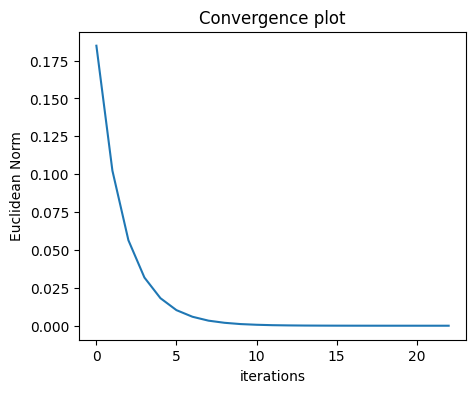


Pagerank importances..
[0.09455921 0.05152265 0.05510965 0.03520661 0.022556   0.02965355
 0.02965355 0.02429308 0.02920398 0.01491851 0.022556   0.01061031
 0.01530453 0.02892046 0.01518063 0.01518063 0.01774383 0.01519009
 0.01518063 0.01981748 0.01518063 0.01519009 0.01518063 0.0313859
 0.02167915 0.02158242 0.01581545 0.02572134 0.01981574 0.02652856
 0.02443306 0.03672917 0.07006385 0.09833262]


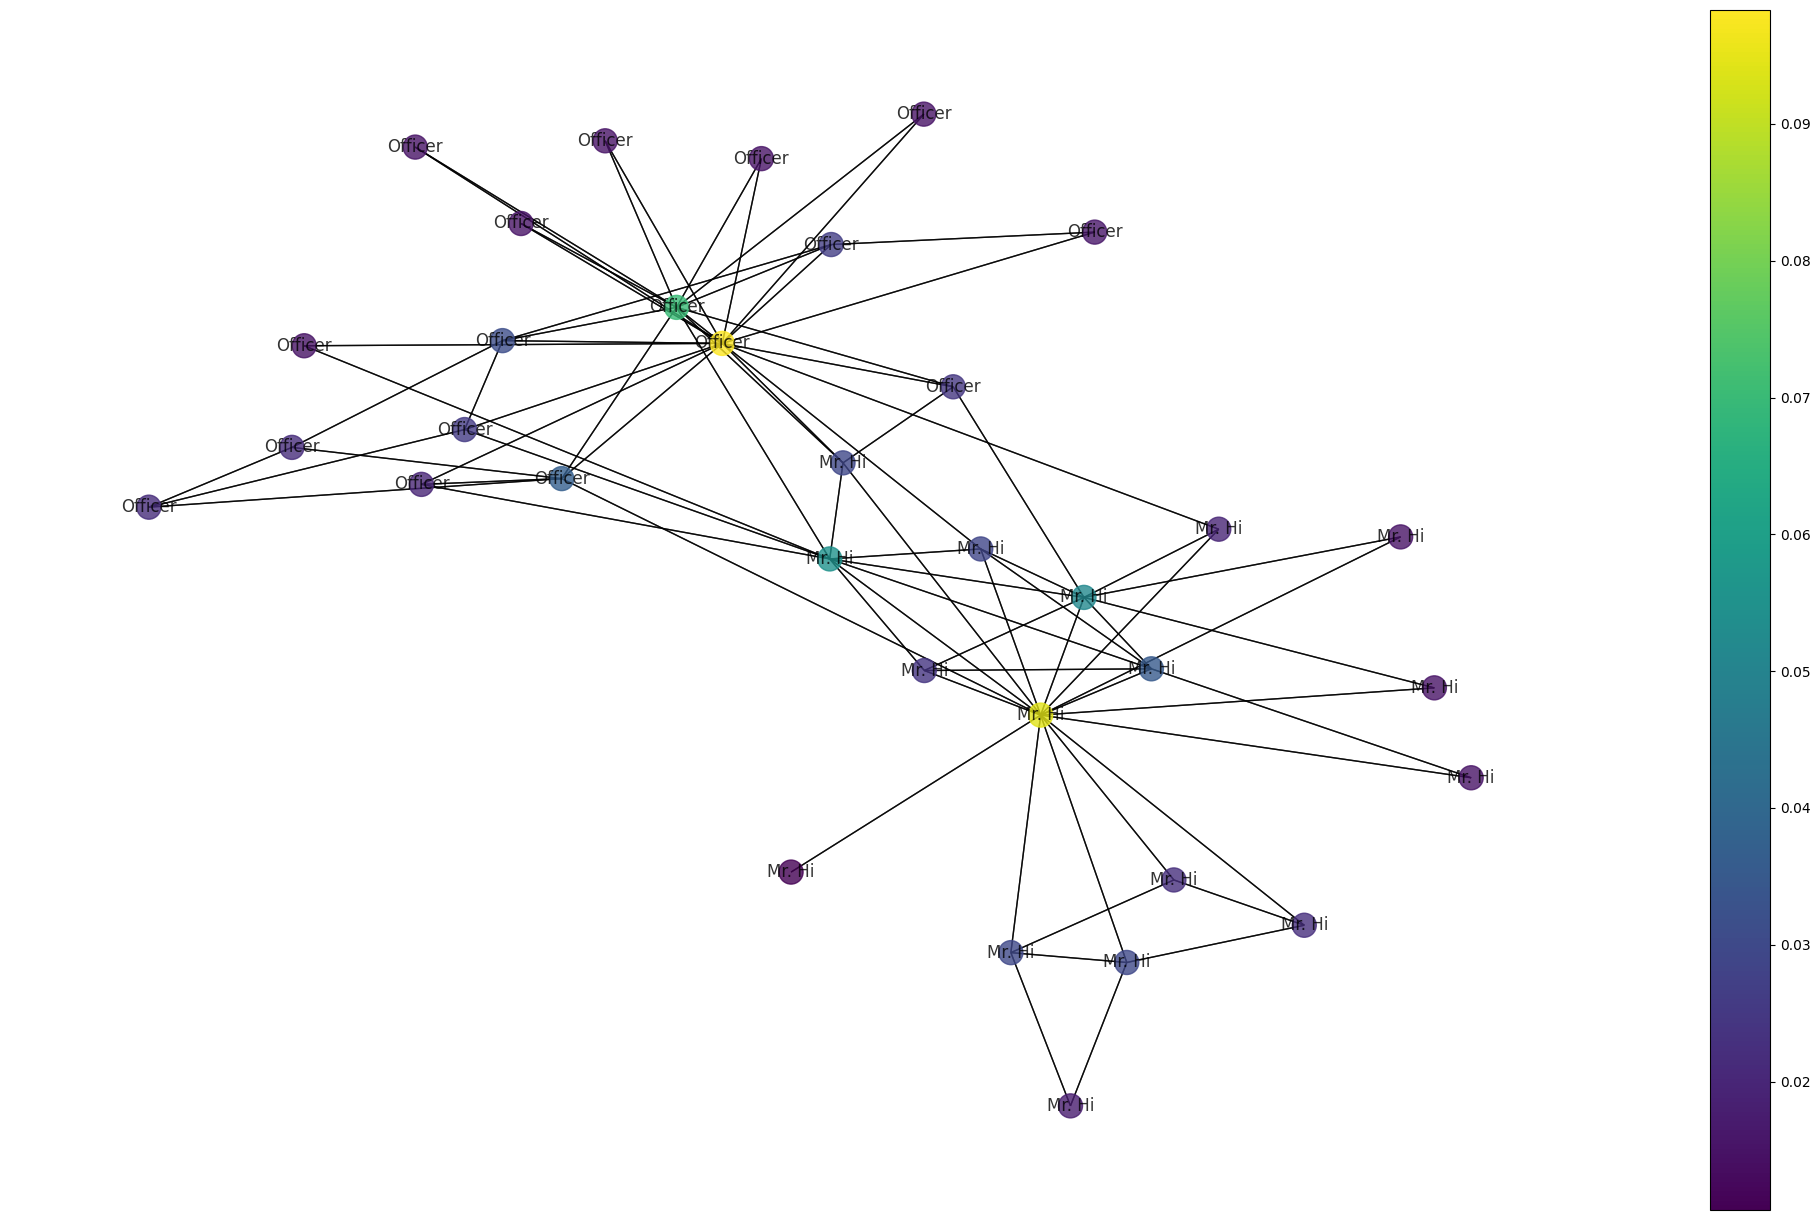

In [27]:
alpha = 0.8
n_iter = 1000

G = nx.karate_club_graph()
final_probs = run(G, alpha, n_iter)

Directed: False
Weighted: False

Graph converted to directed..
Directed: True

Relabelling nodes to integers..
Removing isolated nodes..

Number of nodes:  32
Number of edges:  178

Running random walk..
Converged at 46 iterations..


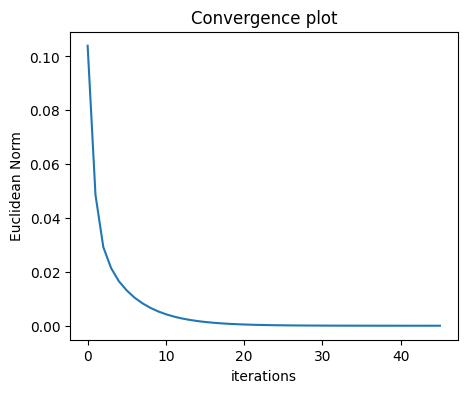


Pagerank importances..
[0.04145404 0.0440897  0.01875878 0.03691868 0.01880887 0.04193673
 0.03829833 0.01884531 0.03659665 0.04127687 0.02379543 0.02913123
 0.06578725 0.01960249 0.04095943 0.02339818 0.01466343 0.03218931
 0.02836729 0.02340157 0.02319995 0.01630935 0.03366245 0.02284269
 0.0225989  0.03425017 0.01630935 0.01960249 0.07048178 0.05060149
 0.02283931 0.0290225 ]


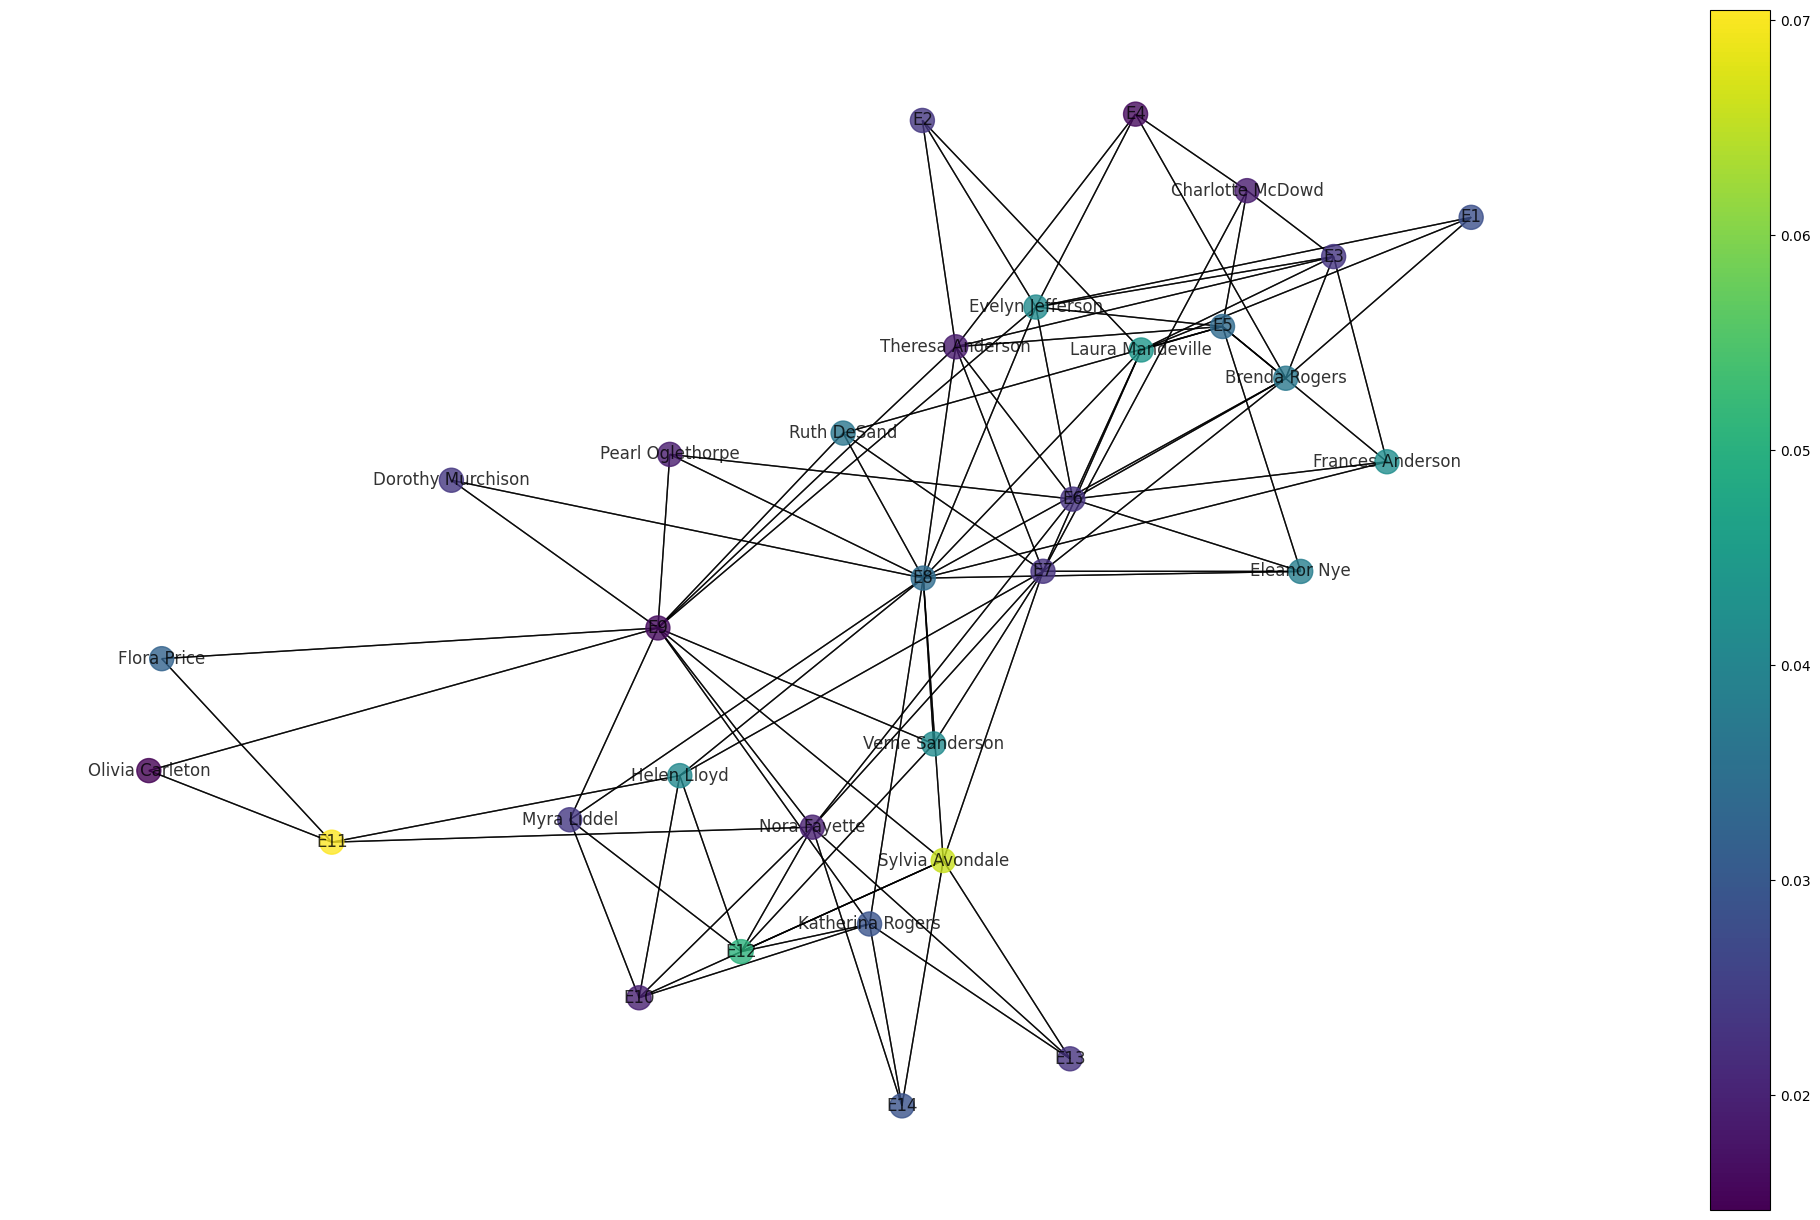

In [28]:
G = nx.davis_southern_women_graph()
final_probs = run(G, alpha, n_iter)

Directed: False
Weighted: False

Graph converted to directed..
Directed: True

Relabelling nodes to integers..
Removing isolated nodes..

Number of nodes:  15
Number of edges:  40

Running random walk..
Converged at 32 iterations..


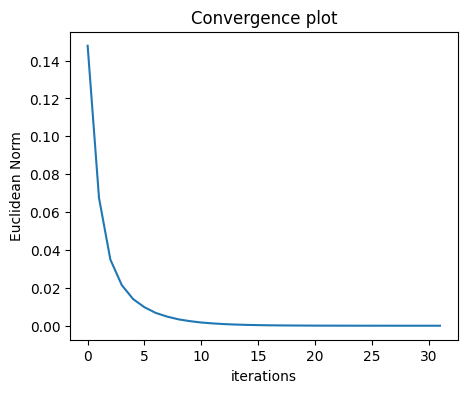


Pagerank importances..
[0.06685932 0.09762247 0.06824114 0.03239548 0.06332677 0.06858391
 0.0857384  0.03454905 0.03285794 0.14296514 0.03866386 0.05068454
 0.06783479 0.0701177  0.07955949]


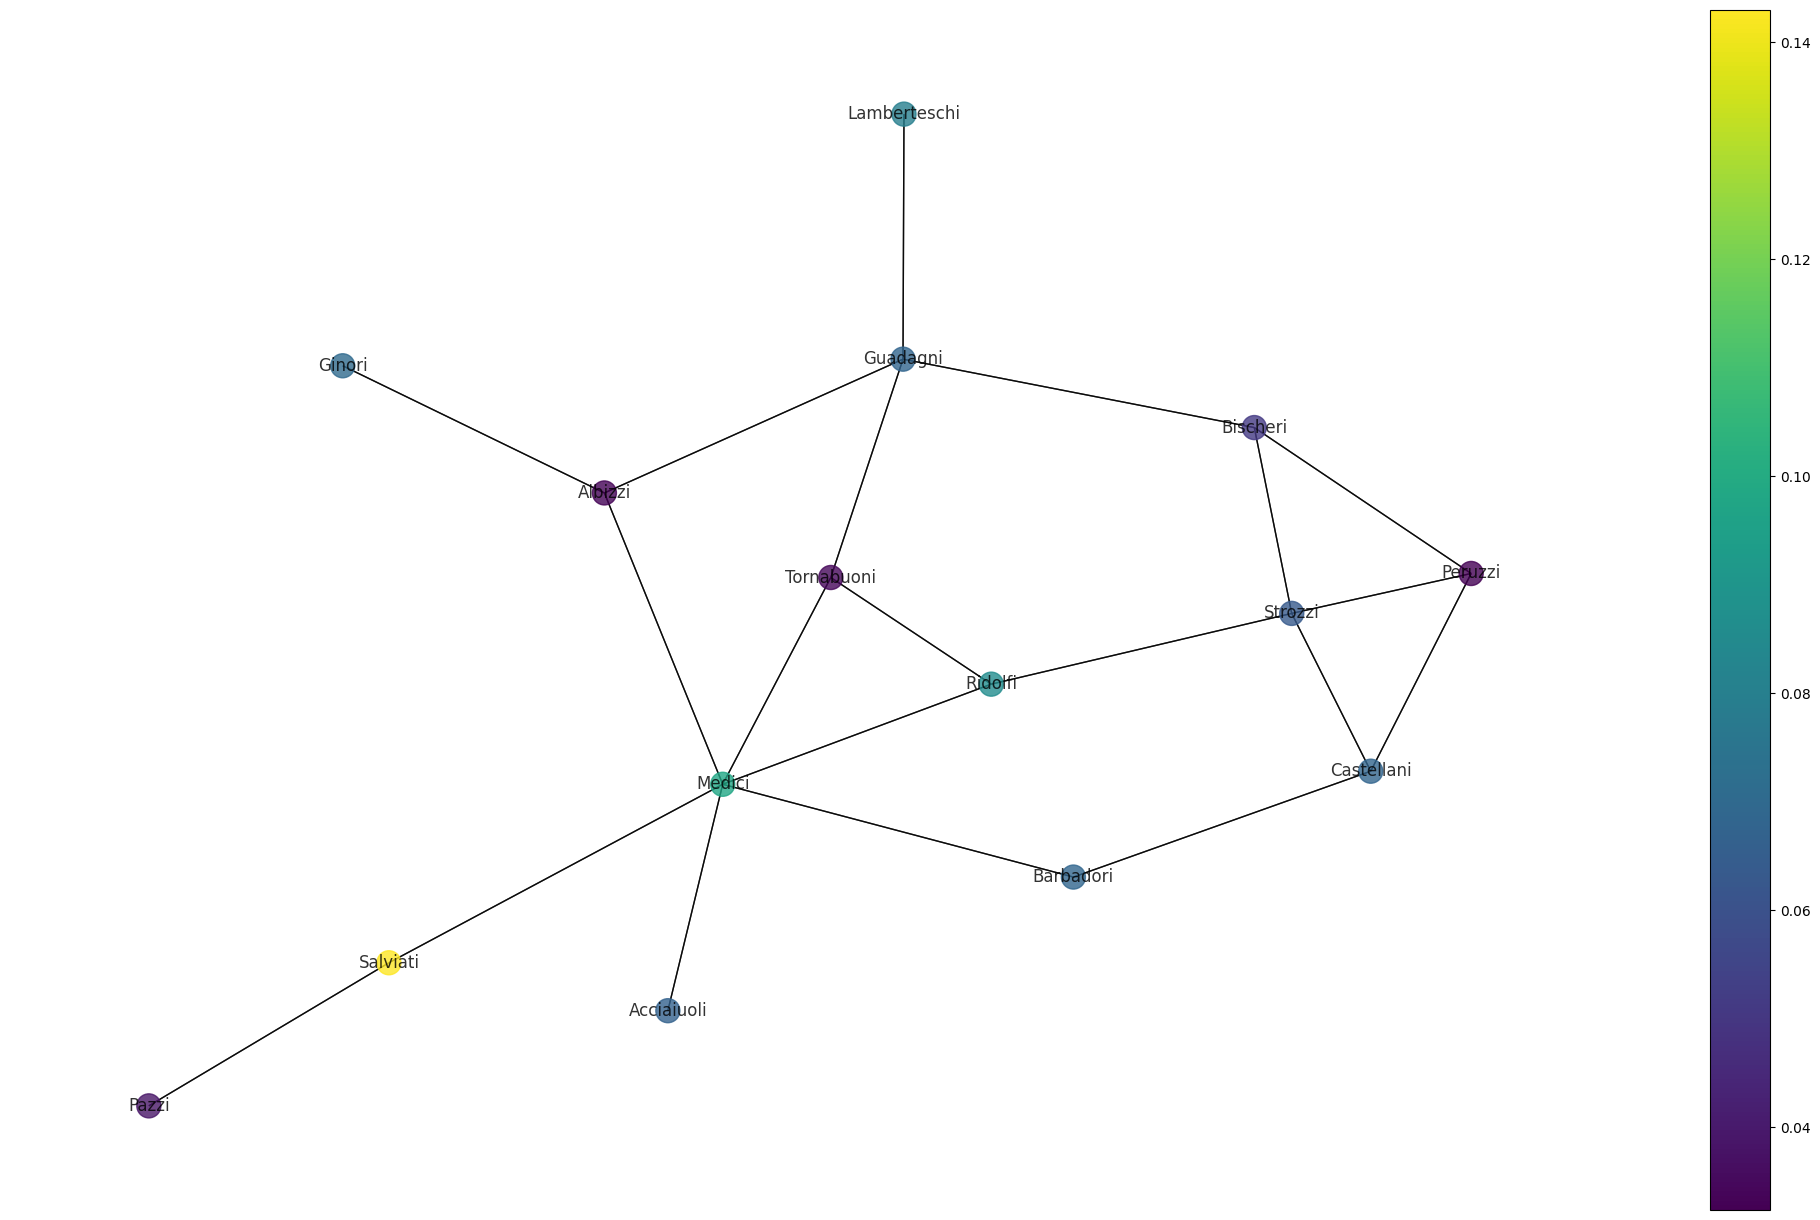

In [30]:
G = nx.florentine_families_graph()
final_probs = run(G, alpha, n_iter)